# Hyperparameter tunning on best Lazy predict Models
Based on the RMSE scores , I select the following models:
* XGBRegressor	
* HistGradientBoostingRegressor	
* LGBMRegressor

And Given that they are not time consuming and we have the Tuners() already, I will also work with:
* LassoCV
* RidgeCV
* KNN

As a base comparisoon , I will also use the DummyRegressor()

In [1]:
import sys
PATH_TO_SRC = '/Users/masaver/Desktop/masaver/data_science_projects/sep24_bds_int_medical'
sys.path.append( PATH_TO_SRC )

# Import the preprocessign pipeline
from pipelines import *

import os
import pandas as pd
import numpy as np
from pprint import pprint as pp
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate

from tqdm import tqdm

# Disable warnings
import warnings
warnings.filterwarnings("ignore") 

# Import metrics for scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_squared_error
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# For plotting
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
# Read and display the train and test data
data_file = os.path.join('..', '..', 'data', 'raw', 'train.csv')
test_file = os.path.join('..', '..', 'data', 'raw', 'test.csv')

df_train = pd.read_csv(data_file, index_col = 0 , parse_dates = True )
df_test = pd.read_csv(test_file, index_col = 0 , parse_dates = True )


In [3]:
# Split the data into Features and Target variables, 
# and Standarize the features with the preprocessing pipelines
X = df_train.drop( 'bg+1:00' , axis = 1 )
y = df_train['bg+1:00']

data_pipe = pipeline
Xs = data_pipe.fit_transform( X )
Xs_test = data_pipe.transform( df_test )

# fix column names - Needed for LGBM
import re
Xs.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs.columns]
Xs_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs_test.columns]

# Display descriptive statistics
display( Xs.describe() )
display( Xs_test.describe() )


,bg_5_55,bg_5_50,bg_5_45,bg_5_40,bg_5_35,bg_5_30,bg_5_25,bg_5_20,bg_5_15,bg_5_10,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,...,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05
mean,6.678999e-17,7.128547e-16,1.746815e-16,-1.066071e-16,-8.862518e-17,-2.568846e-18,-2.851419e-16,7.231301e-16,-2.414715e-16,2.825730e-17,...,1.592684e-16,1.644061e-16,4.623922e-17,-1.541307e-17,2.260584e-16,-3.901434e-17,-1.461031e-17,-1.031552e-17,-7.385432e-18,-1.590276e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.022989e+00,-2.023072e+00,-2.024274e+00,-2.025959e+00,-2.025008e+00,-2.024706e+00,-2.026471e+00,-2.025571e+00,-2.025234e+00,-2.027086e+00,...,-1.132252e+00,-1.131288e+00,-1.131634e+00,-1.132097e+00,-1.134014e+00,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
25%,-7.257353e-01,-7.256400e-01,-7.259481e-01,-7.264489e-01,-7.260141e-01,-7.258175e-01,-7.263474e-01,-7.259236e-01,-7.257157e-01,-7.262965e-01,...,-3.878293e-01,-3.873843e-01,-3.875796e-01,-3.875481e-01,-3.873682e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
50%,-1.935287e-01,-1.933603e-01,-1.933016e-01,-1.933167e-01,-1.930933e-01,-1.929402e-01,-1.929632e-01,-1.927349e-01,-1.925801e-01,-1.926393e-01,...,-3.103131e-01,-3.099221e-01,-3.101018e-01,-3.100189e-01,-3.096205e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
75%,5.382552e-01,5.385243e-01,5.390874e-01,5.397402e-01,5.396728e-01,5.397660e-01,5.404402e-01,5.403995e-01,5.404813e-01,5.411395e-01,...,-1.031577e-01,-1.042468e-01,-1.043850e-01,-1.028285e-01,-1.045274e-01,-4.444915e-01,-2.978734e-01,-4.491221e-01,-5.752456e-01,-4.505926e-01
max,6.492316e+00,6.493403e+00,6.498071e+00,6.504157e+00,6.501724e+00,6.501330e+00,6.507676e+00,6.505448e+00,6.504936e+00,6.511430e+00,...,1.438034e+01,1.437049e+01,1.437327e+01,1.438312e+01,1.442491e+01,2.249762e+00,3.357131e+00,2.226566e+00,1.738388e+00,2.219300e+00


,bg_5_55,bg_5_50,bg_5_45,bg_5_40,bg_5_35,bg_5_30,bg_5_25,bg_5_20,bg_5_15,bg_5_10,...,cals_0_20,cals_0_15,cals_0_10,cals_0_05,cals_0_00,day_phase_evening,day_phase_late_evening,day_phase_morning,day_phase_night,day_phase_noon
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,...,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.184348,0.186197,0.186528,0.184169,0.180827,0.178788,0.180075,0.179307,0.178202,0.179529,...,-0.166944,-0.160694,-0.159051,-0.163727,-0.169704,0.020570,-0.006998,-0.021041,0.015226,0.016126
std,1.115628,1.113388,1.111815,1.107850,1.104784,1.100944,1.095559,1.092830,1.090529,1.088190,...,0.891142,0.891972,0.910754,0.911728,0.933371,1.018330,0.989349,0.981031,1.008840,1.014172
min,-1.823411,-2.023072,-1.891112,-2.025959,-1.958393,-1.924791,-1.837565,-1.858949,-1.891950,-2.027086,...,-1.133589,-1.132624,-1.132969,-1.133433,-1.135355,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
25%,-0.625947,-0.592570,-0.592786,-0.593166,-0.603886,-0.592598,-0.593001,-0.592626,-0.592432,-0.592882,...,-0.534843,-0.534295,-0.534520,-0.534586,-0.537837,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
50%,-0.060477,-0.060290,-0.060140,-0.060034,-0.093171,-0.065272,-0.059617,-0.059438,-0.059296,-0.048107,...,-0.403867,-0.382376,-0.397598,-0.413614,-0.423561,-0.444492,-0.297873,-0.449122,-0.575246,-0.450593
75%,0.804358,0.771397,0.774894,0.750772,0.750621,0.739595,0.740459,0.740345,0.740407,0.766276,...,-0.234133,-0.226784,-0.233960,-0.215112,-0.233213,-0.444492,-0.297873,-0.449122,1.738388,-0.450593
max,6.425790,6.426868,6.431490,6.293126,6.312981,6.334806,6.396555,6.449907,6.504936,6.511430,...,7.689893,7.684706,7.214594,9.294255,9.190347,2.249762,3.357131,2.226566,1.738388,2.219300


Model tunning

In [4]:
# Import the Tuners
from src.features.tuners.XGBHyperparameterTuner import XGBHyperparameterTuner
from src.features.tuners.LGBMHyperparameterTuner import LGBMHyperparameterTuner
from src.features.tuners.HistGradientBoostingHyperparameterTuner import HistGradientBoostingHyperparameterTuner
from src.features.tuners.LassoCVHyperparameterTuner import LassoCVHyperparameterTuner
# from src.features.tuners.RidgeCVHyperparameterTuner import RidgeCVHyperparameterTuner
from src.features.tuners.KNeighborsHyperparameterTuner import KNeighborsHyperparameterTuner
from sklearn.dummy import DummyRegressor


In [5]:
# Instantiate the tuners
# xgb_tuner = XGBHyperparameterTuner( search_space = 'default' )
# lgbm_tuner = LGBMHyperparameterTuner( search_space = 'default' )
# hist_tuner = HistGradientBoostingHyperparameterTuner( search_space = 'default' )
# lasso_tuner = LassoCVHyperparameterTuner( search_space='default' )
# ridge_tuner = RidgeCVHyperparameterTuner( search_space='default' )
# knn_tuner = KNeighborsHyperparameterTuner()
# dummy_reg = DummyRegressor()

In [6]:
# Fit the Tuners 
# xgb_tuner.fit(X=Xs, y=y)
# lgbm_tuner.fit(X=Xs, y=y)
# hist_tuner.fit(X=Xs, y=y)
# lasso_tuner.fit(X=Xs, y=y)
# ridge_tuner.fit(X=Xs, y=y) 
# knn_tuner.fit(X=Xs, y=y)
# dummy_reg.fit(X=Xs, y=y)


In [7]:
# Save the reslts from the Tuners
def save_pickle( obj , file_name ):
    
    import pickle
    # Save to pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

    f.close()

def read_pickle( file_name ):
    import pickle

    # Specify the path to your pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    
    # Open the pickle file in binary read mode and load the object
    with open(file_path, 'rb') as f:
        obj = pickle.load( f )

    f.close()

    return obj


# save_pickle( xgb_tuner , 'xgb_tuner_res' )
# save_pickle( lgbm_tuner , 'lgbm_tuner_res' )
# save_pickle( hist_tuner , 'hist_tuner_res' )
# save_pickle( lasso_tuner , 'lasso_tuner_res' )
# save_pickle( ridge_tuner , 'ridge_tuner_res' )
# save_pickle( knn_tuner , 'knn_tuner_res' )
# save_pickle( dummy_reg , 'dummy_reg_res' )


In [8]:
# Read results from the tuners
xgb_tuner = read_pickle( 'xgb_tuner_res' )
lgbm_tuner= read_pickle( 'lgbm_tuner_res' )
hist_tuner = read_pickle( 'hist_tuner_res' )
lasso_tuner = read_pickle( 'lasso_tuner_res' )
knn_tuner = read_pickle( 'knn_tuner_res' )
dummy_reg = read_pickle( 'dummy_reg_res' )

# Extract Best Models
xgb_best_model = xgb_tuner.get_best_model()
lgbm_best_model = lgbm_tuner.get_best_model()
hist_best_model = hist_tuner.get_best_model()
lasso_best_model = lasso_tuner.get_best_model()
knn_best_model = knn_tuner.get_best_model()

In [9]:
# Print the CV RMSE for the best models
xgb_rmse = root_mean_squared_error( y_true = y , y_pred = xgb_best_model.predict( X = Xs ) )
lgmb_rmse = root_mean_squared_error( y_true = y , y_pred = lgbm_best_model.predict( X = Xs ) )
hist_rmse = root_mean_squared_error( y_true = y , y_pred = hist_best_model.predict( X = Xs ) )
lasso_rmse = root_mean_squared_error( y_true = y , y_pred = lasso_best_model.predict( X = Xs ) )
knn_rmse = root_mean_squared_error( y_true = y , y_pred = knn_best_model.predict( X = Xs ) )
dummy_rmse = root_mean_squared_error( y_true = y , y_pred = dummy_reg.predict( X = Xs ) )

rmse_df = pd.DataFrame({
    'model':['xgb','lgbm','hist','lasso','knn','dummy'],
    'rmse':[xgb_rmse,lgmb_rmse,hist_rmse,lasso_rmse,knn_rmse, dummy_rmse]
})

rmse_df.sort_values( 'rmse' , inplace = True )
rmse_df

,model,rmse
1,lgbm,1.757358
0,xgb,1.880405
2,hist,1.932709
3,lasso,2.056862
4,knn,2.149957
5,dummy,2.996390


Calculate Cross-Validate RMSE scores for Train/Test splits using the top n features ( based on SHAP importance )

In [10]:
def train_test_cv( tuner_res , name_tag):

    from src.features.helpers.ShapWrapper import ShapWrapper

    print(f'Calculating scores for {name_tag}')

    model = tuner_res.get_best_model()
    shap = ShapWrapper( model = model , X = Xs )
    sorted_list = shap.get_top_features()

    train_rmse_vals = []
    test_rmse_vals = []

    for n in tqdm( range(1,101) ):
        # Perform cross-validation, specifying both train and test scores
        cv_results = cross_validate(
            model, Xs[ sorted_list[:n] ], y, cv=5,
            scoring = rmse_scorer , 
            return_train_score=True
        )

        # Extract train and test scores
        train_scores = cv_results['train_score']
        test_scores = cv_results['test_score']

        # Display the results
        # Append final scores
        train_rmse_vals.append( -1*train_scores.mean() )
        test_rmse_vals.append( -1*test_scores.mean() )

        #Create a results df
        res = pd.DataFrame({
            'model':name_tag,
            'train_rmse':train_rmse_vals,
            'test_rmse':test_rmse_vals
        })

    return res


In [11]:
# Load base regressorsors

# xgb_rmse_vals = train_test_cv( xgb_tuner , 'XGBRegressor' )
# lgbm_rmse_vals = train_test_cv( lgbm_tuner , 'LGBMRegressor' )
# hist_rmse_vals = train_test_cv( hist_tuner , 'HistGradientBoostingRegressor' )
# lasso_rmse_vals = train_test_cv( lasso_tuner , 'LassoCV' )
# knn_rmse_vals = train_test_cv( knn_tuner , 'KNeighborsRegressor' )

# rmse_vals_df = pd.concat([ 
#     xgb_rmse_vals.reset_index() , 
#     lgbm_rmse_vals.reset_index() , 
#     hist_rmse_vals.reset_index() 
# ])

# rmse_vals_df.to_csv( './models/results_tables/01_RMSE_at different_topN_features.csv' , index=False )

#Read the global results table
rmse_vals_df = pd.read_csv( './models/results_tables/01_RMSE_at different_topN_features.csv'  )
df_melt = rmse_vals_df.melt( id_vars=['index','model'] , var_name='type' , value_name='rmse' )
df_melt.head()

,index,model,type,rmse
0,0,XGBRegressor,train_rmse,2.122145
1,1,XGBRegressor,train_rmse,2.145826
2,2,XGBRegressor,train_rmse,2.037226
3,3,XGBRegressor,train_rmse,2.030764
4,4,XGBRegressor,train_rmse,2.004605


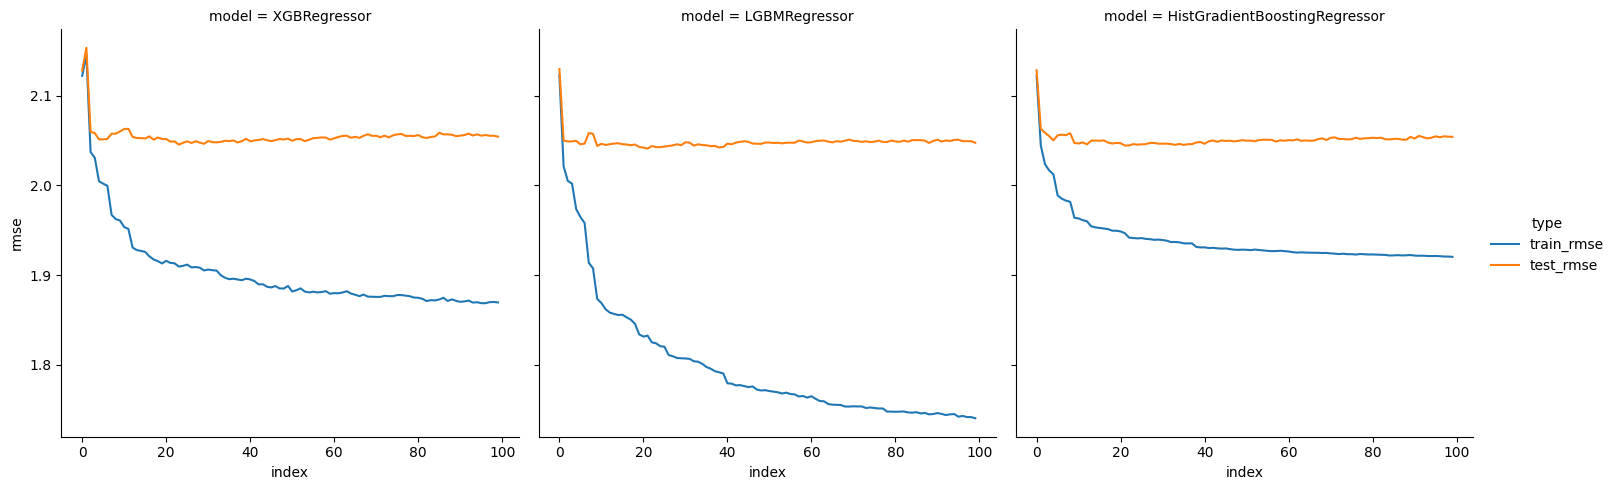

In [12]:
sns.relplot(
    data = df_melt , 
    x = 'index' , 
    y = 'rmse' , 
    hue = 'type' ,
    kind = 'line',
    col= 'model'
)

In [13]:
def print_top_features( tuner , tag , n = 10 ):
    dfs = tuner.get_feature_importance()
    res_l = dfs['feature'][:n].tolist()
    print( f'Top_{n} { tag } fetures: \n{res_l}\n' )
    return res_l

xgboost_top_features = print_top_features( xgb_tuner , 'XGBoost' )
lgbm_top_features = print_top_features( lgbm_tuner , 'LGBM' )
hist_top_features =print_top_features( hist_tuner , 'HistGradientBoosting' )

Top_10 XGBoost fetures: 
['bg_0_00', 'bg_0_05', 'bg_0_10', 'bg_0_15', 'hr_0_00', 'day_phase_night', 'bg_0_20', 'insulin_0_00', 'day_phase_evening', 'hr_0_05']

Top_10 LGBM fetures: 
['bg_0_00', 'bg_0_05', 'bg_0_15', 'bg_0_10', 'hr_0_00', 'day_phase_night', 'day_phase_evening', 'insulin_0_00', 'hr_0_05', 'cals_0_00']

Top_10 HistGradientBoosting fetures: 
['bg_0_00', 'bg_0_15', 'hr_0_00', 'day_phase_night', 'bg_0_10', 'insulin_0_00', 'insulin_0_10', 'day_phase_evening', 'bg_0_20', 'cals_0_00']



In [14]:
common_top_feats = set(xgboost_top_features) & set(lgbm_top_features) & set(hist_top_features)

# Convert back to list if needed
common_top_feats = list(common_top_feats)
common_top_feats

['bg_0_10',
 'bg_0_15',
 'bg_0_00',
 'insulin_0_00',
 'day_phase_evening',
 'hr_0_00',
 'day_phase_night']